In [132]:
# Imports
import pandas as pd
import sqlite3
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt


%matplotlib inline

In [133]:
# Establish a connection to the SQLite3 database
conn = sqlite3.connect('data\im.db')

In [134]:
# Explore the data structure and primary keys
master_table = pd.read_sql("""
SELECT *
FROM sqlite_master
WHERE type = 'table'
""", conn)
master_table

,type,name,tbl_name,rootpage,sql
0,table,movie_basics,movie_basics,2,"CREATE TABLE ""movie_basics"" (\n""movie_id"" TEXT..."
1,table,directors,directors,3,"CREATE TABLE ""directors"" (\n""movie_id"" TEXT,\n..."
2,table,known_for,known_for,4,"CREATE TABLE ""known_for"" (\n""person_id"" TEXT,\..."
3,table,movie_akas,movie_akas,5,"CREATE TABLE ""movie_akas"" (\n""movie_id"" TEXT,\..."
4,table,movie_ratings,movie_ratings,6,"CREATE TABLE ""movie_ratings"" (\n""movie_id"" TEX..."
5,table,persons,persons,7,"CREATE TABLE ""persons"" (\n""person_id"" TEXT,\n ..."
6,table,principals,principals,8,"CREATE TABLE ""principals"" (\n""movie_id"" TEXT,\..."
7,table,writers,writers,9,"CREATE TABLE ""writers"" (\n""movie_id"" TEXT,\n ..."


In [135]:
# Explore each table's contents
print("movie_basics")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM movie_basics
LIMIT 5
""", conn))

print("directors")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM directors
LIMIT 5
""", conn))

print("known_for")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM known_for
LIMIT 5
""", conn))

print("movie_akas")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM movie_akas
LIMIT 5
""", conn))

print("movie_ratings")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM movie_ratings
LIMIT 5
""", conn))

print("persons")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM persons
LIMIT 5
""", conn))

print("principals")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM principals
LIMIT 5
""", conn))

print("writers")
display(pd.read_sql("""
SELECT *, COUNT(*)
FROM writers
LIMIT 5
""", conn))

movie_basics


,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,COUNT(*)
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",146144


directors


,movie_id,person_id,COUNT(*)
0,tt0285252,nm0899854,291174


known_for


,person_id,movie_id,COUNT(*)
0,nm0061671,tt0837562,1638260


movie_akas


,movie_id,ordering,title,region,language,types,attributes,is_original_title,COUNT(*)
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0,331703


movie_ratings


,movie_id,averagerating,numvotes,COUNT(*)
0,tt10356526,8.3,31,73856


persons


,person_id,primary_name,birth_year,death_year,primary_profession,COUNT(*)
0,nm0061671,Mary Ellen Bauder,None,None,"miscellaneous,production_manager,producer",606648


principals


,movie_id,ordering,person_id,category,job,characters,COUNT(*)
0,tt0111414,1,nm0246005,actor,None,"[""The Man""]",1028186


writers


,movie_id,person_id,COUNT(*)
0,tt0285252,nm0899854,255873


Notes:
- SELECT * (movie titles, year, runtime, and genres) FROM movie_basics table by connecting with movie_id
- JOIN movie_ratings USING(movie_id)

In [136]:
df = pd.read_csv('data/tn.movie_budgets.csv')
df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [137]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   id                 5782 non-null   int64 
 1   release_date       5782 non-null   object
 2   movie              5782 non-null   object
 3   production_budget  5782 non-null   object
 4   domestic_gross     5782 non-null   object
 5   worldwide_gross    5782 non-null   object
dtypes: int64(1), object(5)
memory usage: 271.2+ KB


In [138]:
df.describe(include='object')

,release_date,movie,production_budget,domestic_gross,worldwide_gross
count,5782,5782,5782,5782,5782
unique,2418,5698,509,5164,5356
top,"Dec 31, 2014",Halloween,"$20,000,000",$0,$0
freq,24,3,231,548,367


Notes:
- Movies will need to be matched with movie_id while accounting for alternate titles
- CSV includes release date (not just year), budget, domestic gross, worldwide gross

Potential routes of analysis:
- ROI per genre (if wanting best return on investment)
- Ratings per genre (if seeking awards)
- ROI by budget level (to determine a reasonable budget -- Low: <$5M, Medium: $5-50M, High: >$50M)
- ROI by length of movie (to determine best timeframe -- Short: <90 mins, Medium: 90-120 mins, Long: >120 mins)
- Revenue by release month (to determine best month for release)

In [139]:
# Consolidate into one dataframe
# First combine the SQL tables
sql_movies = pd.read_sql("""
SELECT *
FROM movie_basics
    JOIN movie_ratings
        USING(movie_id)
""", conn)

sql_movies.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama",6.1,13
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119


In [140]:
sql_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73856 entries, 0 to 73855
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   movie_id         73856 non-null  object 
 1   primary_title    73856 non-null  object 
 2   original_title   73856 non-null  object 
 3   start_year       73856 non-null  int64  
 4   runtime_minutes  66236 non-null  float64
 5   genres           73052 non-null  object 
 6   averagerating    73856 non-null  float64
 7   numvotes         73856 non-null  int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 4.5+ MB


In [141]:
alt_titles = pd.read_sql("""
SELECT *
FROM movie_akas
""", conn)
alt_titles.head()

,movie_id,ordering,title,region,language,types,attributes,is_original_title
0,tt0369610,10,Джурасик свят,BG,bg,None,None,0.0
1,tt0369610,11,Jurashikku warudo,JP,None,imdbDisplay,None,0.0
2,tt0369610,12,Jurassic World: O Mundo dos Dinossauros,BR,None,imdbDisplay,None,0.0
3,tt0369610,13,O Mundo dos Dinossauros,BR,None,None,short title,0.0
4,tt0369610,14,Jurassic World,FR,None,imdbDisplay,None,0.0


In [142]:
alt_titles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331703 entries, 0 to 331702
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   movie_id           331703 non-null  object 
 1   ordering           331703 non-null  int64  
 2   title              331703 non-null  object 
 3   region             278410 non-null  object 
 4   language           41715 non-null   object 
 5   types              168447 non-null  object 
 6   attributes         14925 non-null   object 
 7   is_original_title  331678 non-null  float64
dtypes: float64(1), int64(1), object(6)
memory usage: 20.2+ MB


In [143]:
# Create a dictionary so that we can match alternate movie titles to the correct movie_id
alt_dict = dict(zip(alt_titles['title'], alt_titles['movie_id']))
len(alt_dict)

252781

In [144]:
# Create a 'movie_id' column in our dataframe by using the map method
# First, create a dictionary of the accepted inputs and desired outputs
alt_dict = dict(zip(alt_titles['title'], alt_titles['movie_id']))

# Then call the method
df['movie_id'] = df['movie'].map(alt_dict)
df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,movie_id
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279",tt1775309
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875",tt1298650
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350",tt6565702
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963",tt2395427
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747",NaN
...,...,...,...,...,...,...,...
5777,78,"Dec 31, 2018",Red 11,"$7,000",$0,$0,tt7837402
5778,79,"Apr 2, 1999",Following,"$6,000","$48,482","$240,495",NaN
5779,80,"Jul 13, 2005",Return to the Land of Wonders,"$5,000","$1,338","$1,338",NaN
5780,81,"Sep 29, 2015",A Plague So Pleasant,"$1,400",$0,$0,tt2107644


In [145]:
merge_df = pd.merge(sql_movies, df, on='movie_id')
merge_df.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,"$45,000,000",$0,"$73,706"
1,tt0339736,The Evil Within,The Evil Within,2017,98.0,Horror,5.6,2420,43,"Oct 10, 2014",Whiplash,"$3,300,000","$13,092,006","$38,969,037"
2,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013",The Secret Life of Walter Mitty,"$91,000,000","$58,236,838","$187,861,183"
3,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014",A Walk Among the Tombstones,"$28,000,000","$26,017,685","$62,108,587"
4,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015",Jurassic World,"$215,000,000","$652,270,625","$1,648,854,864"


In [146]:
"""
Function to replace '$' and commas from 'production_budget', 'domestic_gross', 'worldwide_gross'
Takes in dataframe and column names
Returns cleaned version saved over the original dataframe
"""

def clean_currency_columns(df, columns):
    for column in columns:
        df.loc[:, column] = df[column].replace({'\$': '', ',': ''}, regex=True).astype(float)
    return df

In [147]:
# Defines the columns to clean
columns_to_clean = ['production_budget', 'domestic_gross', 'worldwide_gross']

# Calls the function
merge_df = clean_currency_columns(merge_df, columns_to_clean)
merge_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,73706.0
1,tt0339736,The Evil Within,The Evil Within,2017,98.0,Horror,5.6,2420,43,"Oct 10, 2014",Whiplash,3300000.0,13092006.0,38969037.0
2,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0
3,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014",A Walk Among the Tombstones,28000000.0,26017685.0,62108587.0
4,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015",Jurassic World,215000000.0,652270625.0,1648854864.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,tt9225192,Unstoppable,Seongnan hwangso,2018,116.0,"Action,Crime",6.5,576,1,"Nov 14, 1980",Raging Bull,18000000.0,23380203.0,23380203.0
2188,tt9392532,Neighbors,Neighbors,2018,90.0,"Comedy,Drama",7.6,18,64,"May 9, 2014",Neighbors,18000000.0,150086800.0,270944428.0
2189,tt9415552,Tankers,Nesokrushimyy,2018,90.0,"Action,Drama,History",5.7,1031,27,"Aug 25, 2006",Invincible,40000000.0,57806952.0,58501127.0
2190,tt9680064,Walter,Walter,2019,90.0,Comedy,6.4,35,96,"Mar 13, 2015",Walter,700000.0,0.0,0.0


In [148]:
"""
Function used to compare 'domestic_gross' and 'worldwide_gross' and return the higher value
Takes in dataframe and column names
Returns cleaned version saved over the original dataframe
"""

def calculate_revenue(row):
    if row['domestic_gross'] >= row['worldwide_gross']:
        return row['domestic_gross']
    else:
        return row['worldwide_gross']

merge_df['revenue'] = merge_df.apply(calculate_revenue, axis=1)
merge_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,revenue
0,tt0249516,Foodfight!,Foodfight!,2012,91.0,"Action,Animation,Comedy",1.9,8248,26,"Dec 31, 2012",Foodfight!,45000000.0,0.0,73706.0,7.370600e+04
1,tt0339736,The Evil Within,The Evil Within,2017,98.0,Horror,5.6,2420,43,"Oct 10, 2014",Whiplash,3300000.0,13092006.0,38969037.0,3.896904e+07
2,tt0359950,The Secret Life of Walter Mitty,The Secret Life of Walter Mitty,2013,114.0,"Adventure,Comedy,Drama",7.3,275300,37,"Dec 25, 2013",The Secret Life of Walter Mitty,91000000.0,58236838.0,187861183.0,1.878612e+08
3,tt0365907,A Walk Among the Tombstones,A Walk Among the Tombstones,2014,114.0,"Action,Crime,Drama",6.5,105116,67,"Sep 19, 2014",A Walk Among the Tombstones,28000000.0,26017685.0,62108587.0,6.210859e+07
4,tt0369610,Jurassic World,Jurassic World,2015,124.0,"Action,Adventure,Sci-Fi",7.0,539338,34,"Jun 12, 2015",Jurassic World,215000000.0,652270625.0,1648854864.0,1.648855e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,tt9225192,Unstoppable,Seongnan hwangso,2018,116.0,"Action,Crime",6.5,576,1,"Nov 14, 1980",Raging Bull,18000000.0,23380203.0,23380203.0,2.338020e+07
2188,tt9392532,Neighbors,Neighbors,2018,90.0,"Comedy,Drama",7.6,18,64,"May 9, 2014",Neighbors,18000000.0,150086800.0,270944428.0,2.709444e+08
2189,tt9415552,Tankers,Nesokrushimyy,2018,90.0,"Action,Drama,History",5.7,1031,27,"Aug 25, 2006",Invincible,40000000.0,57806952.0,58501127.0,5.850113e+07
2190,tt9680064,Walter,Walter,2019,90.0,Comedy,6.4,35,96,"Mar 13, 2015",Walter,700000.0,0.0,0.0,0.000000e+00


In [149]:
relevant_cols = [
    'primary_title',
    'runtime_minutes',
    'genres',
    'averagerating',
    "release_date",
    'production_budget',
    'revenue'
]

df_relevant = merge_df[relevant_cols]
df_relevant

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue
0,Foodfight!,91.0,"Action,Animation,Comedy",1.9,"Dec 31, 2012",45000000.0,7.370600e+04
1,The Evil Within,98.0,Horror,5.6,"Oct 10, 2014",3300000.0,3.896904e+07
2,The Secret Life of Walter Mitty,114.0,"Adventure,Comedy,Drama",7.3,"Dec 25, 2013",91000000.0,1.878612e+08
3,A Walk Among the Tombstones,114.0,"Action,Crime,Drama",6.5,"Sep 19, 2014",28000000.0,6.210859e+07
4,Jurassic World,124.0,"Action,Adventure,Sci-Fi",7.0,"Jun 12, 2015",215000000.0,1.648855e+09
...,...,...,...,...,...,...,...
2187,Unstoppable,116.0,"Action,Crime",6.5,"Nov 14, 1980",18000000.0,2.338020e+07
2188,Neighbors,90.0,"Comedy,Drama",7.6,"May 9, 2014",18000000.0,2.709444e+08
2189,Tankers,90.0,"Action,Drama,History",5.7,"Aug 25, 2006",40000000.0,5.850113e+07
2190,Walter,90.0,Comedy,6.4,"Mar 13, 2015",700000.0,0.000000e+00


In [150]:
# Return on Investent (roi) is a percentage gain (or loss) of the initial budget that the movie brought in
df_relevant.loc[:, 'roi'] = (df_relevant['revenue'] - df_relevant['production_budget']) / df_relevant['production_budget'] * 100
df_relevant

C:\Users\Elija\AppData\Local\Temp\ipykernel_44000\402927141.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_relevant.loc[:, 'roi'] = (df_relevant['revenue'] - df_relevant['production_budget']) / df_relevant['production_budget'] * 100


,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,"Action,Animation,Comedy",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209
1,The Evil Within,98.0,Horror,5.6,"Oct 10, 2014",3300000.0,3.896904e+07,1080.879909
2,The Secret Life of Walter Mitty,114.0,"Adventure,Comedy,Drama",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.44086
3,A Walk Among the Tombstones,114.0,"Action,Crime,Drama",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382
4,Jurassic World,124.0,"Action,Adventure,Sci-Fi",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239
...,...,...,...,...,...,...,...,...
2187,Unstoppable,116.0,"Action,Crime",6.5,"Nov 14, 1980",18000000.0,2.338020e+07,29.890017
2188,Neighbors,90.0,"Comedy,Drama",7.6,"May 9, 2014",18000000.0,2.709444e+08,1405.246822
2189,Tankers,90.0,"Action,Drama,History",5.7,"Aug 25, 2006",40000000.0,5.850113e+07,46.252817
2190,Walter,90.0,Comedy,6.4,"Mar 13, 2015",700000.0,0.000000e+00,-100.0


In [151]:
# Split 'genres' to make lists. Then use explode to list each title under each genre
df_relevant.loc[:, 'genres'] = df_relevant['genres'].str.split(',')
df_genre = df_relevant.explode('genres')
df_genre.head()

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,Action,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
0,Foodfight!,91.0,Animation,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
0,Foodfight!,91.0,Comedy,1.9,"Dec 31, 2012",45000000.0,73706.0,-99.836209
1,The Evil Within,98.0,Horror,5.6,"Oct 10, 2014",3300000.0,38969037.0,1080.879909
2,The Secret Life of Walter Mitty,114.0,Adventure,7.3,"Dec 25, 2013",91000000.0,187861183.0,106.44086


In [152]:
# Only a handful of nulls in runtime and in genres
df_relevant.isna().sum()

primary_title         0
runtime_minutes      65
genres                5
averagerating         0
release_date          0
production_budget     0
revenue               0
roi                   0
dtype: int64

In [153]:
genre_counts = df_genre.groupby('genres').size().reset_index(name='count')
genre_counts

,genres,count
0,Action,544
1,Adventure,413
2,Animation,120
3,Biography,167
4,Comedy,658
5,Crime,299
6,Documentary,131
7,Drama,1092
8,Family,125
9,Fantasy,156


In [154]:
# Exclude genres that have less than 30 movies
ratings_by_genre = df_genre.groupby('genres')['averagerating'].mean().round(1).reset_index()
ratings_by_genre = ratings_by_genre.sort_values(by='averagerating', ascending=False)
ratings_by_genre

,genres,averagerating
6,Documentary,7.1
15,News,7.0
3,Biography,6.9
10,History,6.7
20,War,6.6
18,Sport,6.6
21,Western,6.4
2,Animation,6.4
7,Drama,6.4
1,Adventure,6.4


In [165]:
# First, group by genres and calculate both the count and the mean of 'averagerating'
ratings_by_genre = df_genre.groupby('genres').agg(
    count=('averagerating', 'size'),  # Get the count of movies in each genre
    averagerating=('averagerating', 'mean')  # Get the mean of 'averagerating'
)

# Filter out genres with a count less than 30
ratings_by_genre = ratings_by_genre[ratings_by_genre['count'] >= 30]

# Round the average rating to 1 decimal place
ratings_by_genre['averagerating'] = ratings_by_genre['averagerating'].round(1)

# Sort by 'averagerating' in descending order
ratings_by_genre = ratings_by_genre.sort_values(by='averagerating', ascending=False).reset_index()

# Show the final DataFrame
print(ratings_by_genre)


         genres  count  averagerating
0   Documentary    131            7.1
1     Biography    167            6.9
2       History     65            6.7
3           War     39            6.6
4         Sport     49            6.6
5         Music     65            6.4
6     Animation    120            6.4
7         Drama   1092            6.4
8     Adventure    413            6.4
9       Romance    244            6.3
10        Crime    299            6.2
11       Sci-Fi    169            6.2
12       Action    544            6.1
13       Family    125            6.1
14       Comedy    658            6.1
15      Mystery    158            6.0
16      Fantasy    156            6.0
17     Thriller    352            5.9
18       Horror    288            5.4


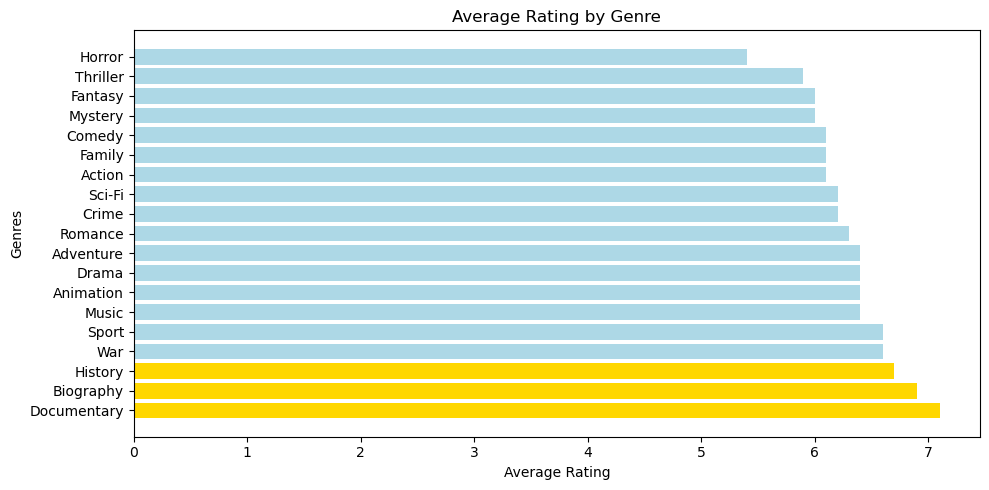

In [156]:
colors = ['gold' if i < 3 else 'lightblue' for i in range(len(ratings_by_genre))]

fig, ax = plt.subplots(figsize=(10, 5))
ax.barh(ratings_by_genre['genres'], ratings_by_genre['averagerating'], color=colors)
ax.set_title('Average Rating by Genre')
ax.set_xlabel('Average Rating')
ax.set_ylabel('Genres')
plt.tight_layout();

Recommendation 1: Create a historical movie, a biography, or a documentary.

Next area of focus: ROI by budget level (to determine a reasonable budget -- Low: <$5M, Medium: $5-50M, High: >$50M)

In [158]:
df_relevant

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209
1,The Evil Within,98.0,[Horror],5.6,"Oct 10, 2014",3300000.0,3.896904e+07,1080.879909
2,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.44086
3,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382
4,Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239
...,...,...,...,...,...,...,...,...
2187,Unstoppable,116.0,"[Action, Crime]",6.5,"Nov 14, 1980",18000000.0,2.338020e+07,29.890017
2188,Neighbors,90.0,"[Comedy, Drama]",7.6,"May 9, 2014",18000000.0,2.709444e+08,1405.246822
2189,Tankers,90.0,"[Action, Drama, History]",5.7,"Aug 25, 2006",40000000.0,5.850113e+07,46.252817
2190,Walter,90.0,[Comedy],6.4,"Mar 13, 2015",700000.0,0.000000e+00,-100.0


In [159]:
# We need to drop films that did not bring in any revenue so that it does not skew our data.
df_relevant.loc[df_relevant['revenue'] == 0]

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
6,Anderson's Cross,98.0,"[Comedy, Drama, Romance]",5.5,"Dec 31, 2010",300000.0,0.0,-100.0
26,House at the End of the Drive,91.0,"[Horror, Thriller]",6.5,"Dec 31, 2014",1400000.0,0.0,-100.0
39,Barry Munday,95.0,"[Comedy, Drama, Romance]",5.9,"Oct 1, 2010",3000000.0,0.0,-100.0
99,The Dead Undead,89.0,"[Action, Horror, Sci-Fi]",3.0,"Dec 31, 2010",1100000.0,0.0,-100.0
102,Freaky Deaky,90.0,"[Comedy, Crime, Thriller]",6.1,"Dec 31, 2011",6000000.0,0.0,-100.0
...,...,...,...,...,...,...,...,...
2137,Rust,100.0,[Drama],6.6,"Oct 5, 2010",250000.0,0.0,-100.0
2152,Red 11,77.0,"[Horror, Sci-Fi, Thriller]",5.6,"Dec 31, 2018",7000.0,0.0,-100.0
2164,Blinded by the Light,117.0,"[Biography, Comedy, Drama]",6.2,"Aug 14, 2019",15000000.0,0.0,-100.0
2185,Butterfly,80.0,"[Documentary, Sport]",7.8,"Dec 31, 2010",250000.0,0.0,-100.0


In [160]:
# Drop rows where revenue = 0
df_pos_rev = df_relevant.loc[df_relevant['revenue'] != 0]
df_pos_rev

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi
0,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209
1,The Evil Within,98.0,[Horror],5.6,"Oct 10, 2014",3300000.0,3.896904e+07,1080.879909
2,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.44086
3,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382
4,Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239
...,...,...,...,...,...,...,...,...
2186,The Villagers,99.0,"[Action, Thriller]",5.7,"Sep 19, 1980",6000000.0,5.230298e+07,771.7163
2187,Unstoppable,116.0,"[Action, Crime]",6.5,"Nov 14, 1980",18000000.0,2.338020e+07,29.890017
2188,Neighbors,90.0,"[Comedy, Drama]",7.6,"May 9, 2014",18000000.0,2.709444e+08,1405.246822
2189,Tankers,90.0,"[Action, Drama, History]",5.7,"Aug 25, 2006",40000000.0,5.850113e+07,46.252817


In [161]:
# Check we only dropped rows where revenue = 0
2192 - 201

1991

In [162]:
# Low: <$5M, Medium: $5-50M, High: >$50M
def assign_budget_level(revenue):
    if revenue < 5000000:
        return 'Low'
    elif 5000000 <= revenue <= 50000000:
        return 'Medium'
    else:
        return 'High'

In [166]:
# df['movie_id'] = df['movie'].map(alt_dict)
df_pos_rev.loc[:, 'budget_level'] = df_pos_rev['revenue'].map(assign_budget_level)
df_pos_rev

,primary_title,runtime_minutes,genres,averagerating,release_date,production_budget,revenue,roi,budget_level
0,Foodfight!,91.0,"[Action, Animation, Comedy]",1.9,"Dec 31, 2012",45000000.0,7.370600e+04,-99.836209,Low
1,The Evil Within,98.0,[Horror],5.6,"Oct 10, 2014",3300000.0,3.896904e+07,1080.879909,Medium
2,The Secret Life of Walter Mitty,114.0,"[Adventure, Comedy, Drama]",7.3,"Dec 25, 2013",91000000.0,1.878612e+08,106.44086,High
3,A Walk Among the Tombstones,114.0,"[Action, Crime, Drama]",6.5,"Sep 19, 2014",28000000.0,6.210859e+07,121.816382,High
4,Jurassic World,124.0,"[Action, Adventure, Sci-Fi]",7.0,"Jun 12, 2015",215000000.0,1.648855e+09,666.909239,High
...,...,...,...,...,...,...,...,...,...
2186,The Villagers,99.0,"[Action, Thriller]",5.7,"Sep 19, 1980",6000000.0,5.230298e+07,771.7163,High
2187,Unstoppable,116.0,"[Action, Crime]",6.5,"Nov 14, 1980",18000000.0,2.338020e+07,29.890017,Medium
2188,Neighbors,90.0,"[Comedy, Drama]",7.6,"May 9, 2014",18000000.0,2.709444e+08,1405.246822,High
2189,Tankers,90.0,"[Action, Drama, History]",5.7,"Aug 25, 2006",40000000.0,5.850113e+07,46.252817,High


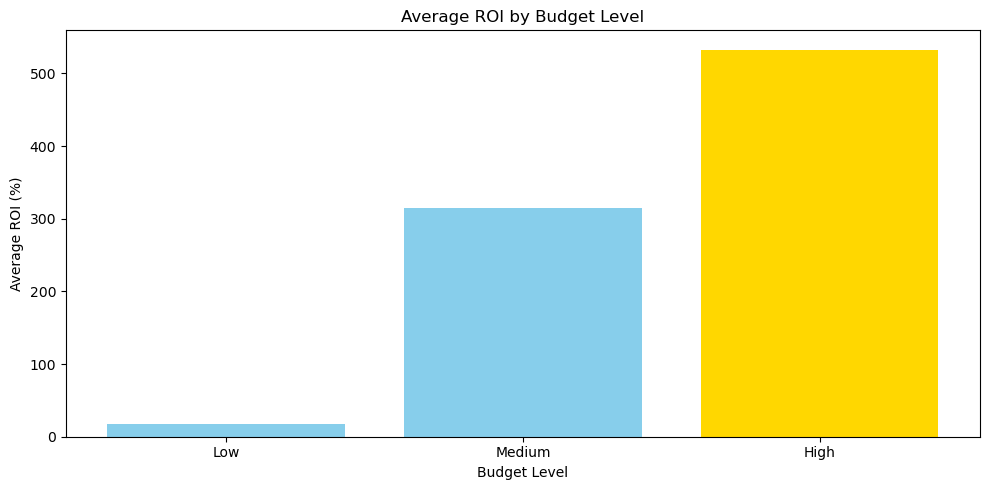

In [186]:
# Convert 'budget_level' to a categorical type with the specific order
order = ['Low', 'Medium', 'High']
mean_roi_by_budget['budget_level'] = pd.Categorical(mean_roi_by_budget['budget_level'], categories=order, ordered=True)

# Sort the DataFrame based on the categorical order
mean_roi_by_budget = mean_roi_by_budget.sort_values('budget_level')

# Determine the colors: gold for the highest return, others in blue
colors = ['gold' if roi == mean_roi_by_budget['roi'].max() else 'skyblue' for roi in mean_roi_by_budget['roi']]

# Plot the bar graph
fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(mean_roi_by_budget['budget_level'], mean_roi_by_budget['roi'], color=colors)
ax.set_title('Average ROI by Budget Level')
ax.set_xlabel('Budget Level')
ax.set_ylabel('Average ROI (%)')
plt.tight_layout();

H0: Average ROI is not significantly different between low budget, medium budget, and high budget films.

H1: Average ROI is significantly different between low budget, medium budget, and high budget films.

Because we know are looking for difference in either direction and we are dealing with categories I will use Chi Squared test.

Recommendation 2: Secure a minimum production budget of $5M (the more funding the better)